# Solución etapa 4 - Training - Predict - Fallos v1

In [43]:
# Utilidades para print
from utils.print_utils import tabl, headr, titl
from utils.explore_utils import explr

In [59]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from skforecast.recursive import ForecasterRecursive
from skforecast.direct import ForecasterDirect

from skforecast.model_selection import backtesting_forecaster
from skforecast.datasets import fetch_dataset
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import grid_search_forecaster

In [10]:
version_to_load = 'v1'

In [11]:
# Cargar el dataset
csv_path = f'../data/preprocessed/preprocessed_data_{version_to_load}.csv'
print('... Loading:', csv_path, '...')
final_data = pd.read_csv(csv_path)

tabl(final_data)

... Loading: ../data/preprocessed/preprocessed_data_v1.csv ...
      ID_Equipo  Fecha         Temperatura_C    Vibracion_mm_s    Horas_Operativas    Fallo  Tipo_Equipo    Fabricante    Modelo      Potencia_kW    Horas_Recomendadas_Revision
--  -----------  ----------  ---------------  ----------------  ------------------  -------  -------------  ------------  --------  -------------  -----------------------------
 0            1  2021-01-01          34.7499          2.13681                  614        0  Bomba          Fabricante_C  Modelo_6            173                            913
 1            1  2021-01-03          56.2006          1.52939                  658        0  Bomba          Fabricante_C  Modelo_6            173                            913
 2            1  2021-01-04          70.5556          3.41101                  664        0  Bomba          Fabricante_C  Modelo_6            173                            913
 3            1  2021-01-05          97.509         

In [12]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731749 entries, 0 to 731748
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   ID_Equipo                    731749 non-null  int64  
 1   Fecha                        731749 non-null  object 
 2   Temperatura_C                731749 non-null  float64
 3   Vibracion_mm_s               731749 non-null  float64
 4   Horas_Operativas             731749 non-null  int64  
 5   Fallo                        731749 non-null  float64
 6   Tipo_Equipo                  731749 non-null  object 
 7   Fabricante                   731749 non-null  object 
 8   Modelo                       731749 non-null  object 
 9   Potencia_kW                  731749 non-null  int64  
 10  Horas_Recomendadas_Revision  731749 non-null  int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 61.4+ MB


In [13]:
target_forecast_column = 'Horas_Operativas'
target_class_column = 'Fallo'

In [14]:
# Steps y lags
steps = 15
lags = 50

## Funciones procesado

In [15]:
# Preparar el dataset

def prep_equipo(equipo):
    equipo.drop(columns=['ID_Equipo', 'Tipo_Equipo', 'Modelo', 'Potencia_kW',
                'Horas_Recomendadas_Revision', 'Fabricante'], inplace=True)

    equipo['Fecha'] = pd.to_datetime(equipo['Fecha'], format='%Y-%m-%d')

    # fecha como índice
    equipo = equipo.set_index('Fecha')

    # Eliminar índices duplicados (mantener el primero)
    equipo_clean = equipo[~equipo.index.duplicated(keep='first')]
    equipo_clean[equipo_clean.index.duplicated()]

    # Convierte Timeseries a frecuencia especificada.
    equipo_fq = equipo_clean.asfreq('D', fill_value=0)

    # print(equipo_fq.info())

    return equipo_fq

In [16]:
# Separación datos train-test

def sep_train_test(equipo_fq, steps, doPlot=True):
    steps = steps
    datos_train = equipo_fq[:-steps]
    datos_test = equipo_fq[-steps:]
    # print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
    # print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

    if (doPlot):
        fig, ax = plt.subplots(figsize=(16, 5))
        datos_train['Horas_Operativas'].plot(ax=ax, label='train')
        datos_test['Horas_Operativas'].plot(ax=ax, label='test')
        ax.legend()

    return datos_train, datos_test

In [17]:
# Búsqueda de hiperparámetros: grid search

def search_best_forecaster(steps, lags_grid, param_grid, datos_train, exogs_train, target_column):
    forecaster = ForecasterRecursive(
        regressor=Ridge(random_state=123),
        transformer_y=StandardScaler(),
        lags=30
    )

    # Particiones de entrenamiento y validación
    cv = TimeSeriesFold(
        steps=steps,
        initial_train_size=int(len(datos_train) * 0.5),
        refit=False,
        fixed_train_size=False,
    )

    resultados_grid = grid_search_forecaster(
        forecaster=forecaster,
        y=datos_train[target_column],
        cv=cv,
        param_grid=param_grid,
        lags_grid=lags_grid,
        metric='mean_squared_error',
        return_best=True,
        n_jobs='auto',
        verbose=False,
        exog=exogs_train,
    )

    # Resultados de la búsqueda de hiperparámetros
    bestfc = resultados_grid.loc[0]

    return bestfc

In [18]:
# Generar modelo final

def gen_finalModel(steps, best_lags, best_params, datos_train, exogs_train, target_column):
    # Crear y entrenar forecaster final
    forecaster = ForecasterRecursive(
        regressor=Ridge(alpha=best_params['alpha'], random_state=123),
        transformer_y=StandardScaler(),
        lags=best_lags
    )

    forecaster.fit(y=datos_train[target_column], exog=exogs_train)

    return forecaster

In [19]:
# Evaluar error

def get_error(target_column, predicciones, equipo_fq, datos_test):
    # Error test
    error_mse = mean_squared_error(
        y_true=datos_test[target_column],
        y_pred=predicciones
    )

    data_var = equipo_fq[target_column].var()

    mse2var = round(error_mse/data_var*100, 2)

    print(f"Error de test (mse): {error_mse}")
    print(f"Varianza datos: {data_var}")
    print(f"mse2var: {mse2var}%")

    return mse2var

In [20]:
# Ingeniería de características en residuos
def create_features_w_residuals(data, residuals, lags):
    features = pd.DataFrame(index=data.index)
    for lag in range(1, lags + 1):
        features[f'lag_{lag}'] = data.shift(lag)

    features['residuals'] = residuals
    features.dropna(inplace=True)

    return features

## Un equipo

In [21]:
eq = 1

best_lags = 50
best_params = {'alpha': 0.1}

In [22]:
# Filtrar el df del equipo
equipo = final_data[final_data['ID_Equipo'] == eq].copy()

# Preparar el dataset para el equipo seleccionado
equipo_fq = prep_equipo(equipo)

equipo_fq

,Temperatura_C,Vibracion_mm_s,Horas_Operativas,Fallo
Fecha,,,,
2021-01-01,34.749896,2.136812,614,0.0
2021-01-02,0.000000,0.000000,0,0.0
2021-01-03,56.200558,1.529395,658,0.0
2021-01-04,70.555608,3.411009,664,0.0
2021-01-05,97.509000,0.618757,683,0.0
...,...,...,...,...
2024-12-27,38.587761,2.748949,808,0.0
2024-12-28,90.397197,5.382844,812,0.0
2024-12-29,21.104524,5.686564,824,0.0


In [23]:
# Exógenos para el modelo
exogs = equipo_fq.drop(columns=target_forecast_column)
exogs_train = equipo_fq.drop(columns=target_forecast_column)[:-steps]
exogs_test = equipo_fq.drop(columns=target_forecast_column)[-steps:]

In [24]:
exogs[:-steps]

,Temperatura_C,Vibracion_mm_s,Fallo
Fecha,,,
2021-01-01,34.749896,2.136812,0.0
2021-01-02,0.000000,0.000000,0.0
2021-01-03,56.200558,1.529395,0.0
2021-01-04,70.555608,3.411009,0.0
2021-01-05,97.509000,0.618757,0.0
...,...,...,...
2024-12-12,47.524678,0.731239,0.0
2024-12-13,48.043295,8.836478,0.0
2024-12-14,72.829938,0.553675,0.0


In [25]:
# modelo final
final_model = gen_finalModel(steps, best_lags, best_params, equipo_fq[:-steps], exogs_train, target_forecast_column)

# Predicciones
predicciones = final_model.predict(steps=steps, exog=exogs_test)

In [26]:
# Crear y entrenar forecaster final
forecaster = ForecasterRecursive(
    regressor=Ridge(alpha=best_params['alpha'], random_state=123),
    transformer_y=StandardScaler(),
    lags=best_lags
)

forecaster.fit(y=equipo_fq[target_forecast_column])

In [27]:
# Predicciones
predicciones = forecaster.predict(steps=len(equipo_fq))

In [28]:
predicciones.shape

(1461,)

In [29]:
# residuos
residuals = equipo_fq[target_forecast_column] - predicciones.values

residuals

Fecha
2021-01-01    572.291471
2021-01-02    -57.587057
2021-01-03    583.999992
2021-01-04    577.053389
2021-01-05    582.901752
                 ...    
2024-12-27    520.634529
2024-12-28    524.634529
2024-12-29    536.634529
2024-12-30    540.634529
2024-12-31   -265.365471
Freq: D, Name: Horas_Operativas, Length: 1461, dtype: float64

## Clasificador

In [30]:
X = create_features_w_residuals(equipo_fq[target_forecast_column], residuals, lags)
y = equipo_fq[target_class_column].iloc[len(equipo_fq) - len(X):]

tabl(X.tail())
y

Fecha                  lag_1    lag_2    lag_3    lag_4    lag_5    lag_6    lag_7    lag_8    lag_9    lag_10    lag_11    lag_12    lag_13    lag_14    lag_15    lag_16    lag_17    lag_18    lag_19    lag_20    lag_21    lag_22    lag_23    lag_24    lag_25    lag_26    lag_27    lag_28    lag_29    lag_30    lag_31    lag_32    lag_33    lag_34    lag_35    lag_36    lag_37    lag_38    lag_39    lag_40    lag_41    lag_42    lag_43    lag_44    lag_45    lag_46    lag_47    lag_48    lag_49    lag_50    residuals
-------------------  -------  -------  -------  -------  -------  -------  -------  -------  -------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  ----

Fecha
2021-02-20    0.0
2021-02-21    0.0
2021-02-22    0.0
2021-02-23    0.0
2021-02-24    0.0
             ... 
2024-12-27    0.0
2024-12-28    0.0
2024-12-29    0.0
2024-12-30    0.0
2024-12-31    1.0
Freq: D, Name: Fallo, Length: 1411, dtype: float64

In [31]:
# Dividir en entrenamiento y prueba

X_train, X_test = X[:-steps], X[-steps:]
y_train, y_test = y[:-steps], y[-steps:]

### Pipelines

In [60]:
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier

from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit

from utils.best_model_utils import cv_train, generate_learning_curves, generate_validation_curves

In [61]:
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)


print(headr("Numerical columns"), numerical_columns)
print(headr("Categorical columns"), categorical_columns)


Numerical columns
 ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18', 'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24', 'lag_25', 'lag_26', 'lag_27', 'lag_28', 'lag_29', 'lag_30', 'lag_31', 'lag_32', 'lag_33', 'lag_34', 'lag_35', 'lag_36', 'lag_37', 'lag_38', 'lag_39', 'lag_40', 'lag_41', 'lag_42', 'lag_43', 'lag_44', 'lag_45', 'lag_46', 'lag_47', 'lag_48', 'lag_49', 'lag_50', 'residuals']

Categorical columns
 []


In [62]:
# Preprocesamiento para variables categóricas
categorical_transformer = Pipeline(steps=[
    # ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Preprocesamiento para variables continuas
numerical_transformer = Pipeline(steps=[
    # ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Combinar preprocesadores
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ]
)

In [63]:
pipelines = {
    "LogisticRegression": Pipeline([('preprocessor', preprocessor),('classifier', LogisticRegression())]),
    "GradientBoostingClassifier": Pipeline([('preprocessor', preprocessor),('classifier', GradientBoostingClassifier())]),
    # "SVC": Pipeline([('preprocessor', preprocessor),('classifier', SVC(kernel='linear'))]),
    # "SGDClassifier": Pipeline([('preprocessor', preprocessor),('classifier', SGDClassifier())]),
}

### CV

In [64]:
# Config CV
cvss = ShuffleSplit(n_splits=40, test_size=0.2, random_state=0)

In [65]:
# Aplicar CV
results = {}

for name, pipeline in pipelines.items():
    print(headr(f"Entrenar {name}"))
    results[name] = cv_train(name, pipeline, cvss, X_train, y_train, X_test, y_test)

print(titl("Resultados:"))
results_df=pd.DataFrame(results)
tabl(results_df)


Entrenar LogisticRegression

test score (mean-std): 0.98 - 0.01
train score (mean-std): 0.98 - 0.00
params: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

Entrenar GradientBoostingClassifier

test score (mean-std): 0.99 - 0.00
train score (mean-std): 1.00 - 0.00
params: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}

** RESULTADOS: **

       LogisticRegression    G

### Curva de aprendizaje

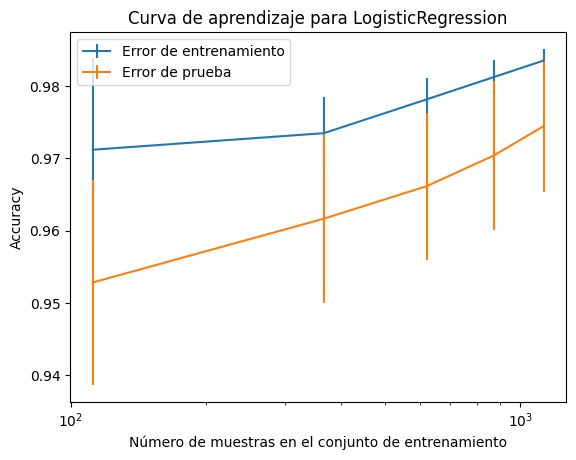

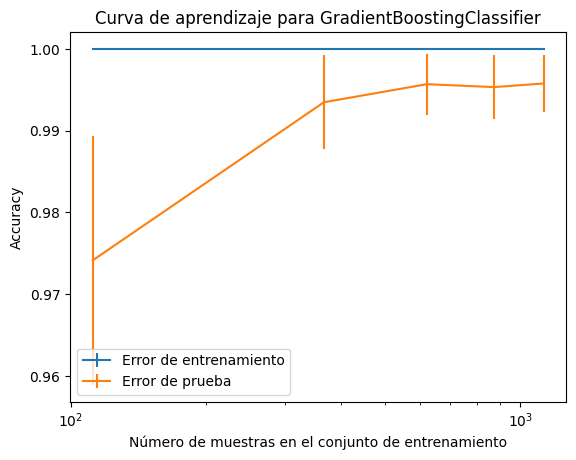

In [66]:
# Aplicar LC
train_sizes = np.linspace(0.1, 1.0, num=5, endpoint=True)

for pipeline_name, pipeline_obj in pipelines.items():
    generate_learning_curves(pipeline_name, pipeline_obj, X, y, train_sizes, cvss)

### Curva validación

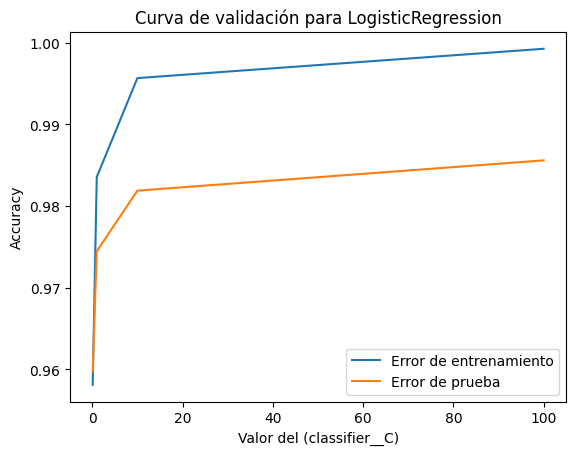

In [50]:
pname = 'LogisticRegression'
Cs = [0.1, 1, 10, 100]
# Cs = [5, 10, 15]
generate_validation_curves(pname, pipelines[pname], X, y, 'classifier__C', Cs, cvss)

### Afinar hiperparámentros

#### LogisticRegression

In [51]:
from sklearn.model_selection import GridSearchCV

pname = 'LogisticRegression'

param_grid = {
    'classifier__C': [5, 10, 15],
    # 'classifier__penalty': ['l1', 'l2', 'elasticnet', None],
    'classifier__solver': ['lbfgs', 'liblinear', 'newto-cg', 'newto-cholesky', 'sag', 'saga']
    # 'classifier__max_iter': [1,10,100,1000]
}

grid_search = GridSearchCV(
    pipelines[pname], param_grid, cv=cvss, scoring="accuracy")

grid_search.fit(X_train, y_train)

print(headr(pname))
print("Mejores hiperparámetros:", grid_search.best_params_)
print(f"Mejor accuracy: {grid_search.best_score_:.2f}")

C:\Users\ricar\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ricar\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ricar\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ricar\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ricar\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ricar\


LogisticRegression

Mejores hiperparámetros: {'classifier__C': 15, 'classifier__solver': 'lbfgs'}
Mejor accuracy: 0.98


## re-entrenar + re-evaluar

In [55]:
# Definir pipelines con mejores hiperparámetros
pipelines = {
    "LogisticRegression": Pipeline([('preprocessor', preprocessor),('classifier', LogisticRegression(C=15,solver='lbfgs'))]),
    # "GradientBoostingClassifier": Pipeline([('preprocessor', preprocessor),('classifier', GradientBoostingClassifier())]),
    # "SVC": Pipeline([('preprocessor', preprocessor),('classifier', SVC(kernel='linear'))]),
    # "SGDClassifier": Pipeline([('preprocessor', preprocessor),('classifier', SGDClassifier())]),
}

# Aplicar CV
results = {}

for name, pipeline in pipelines.items():
    print(headr(f"Entrenar {name}"))
    results[name] = cv_train(name, pipeline, cvss, X_train, y_train, X_test, y_test)


Entrenar LogisticRegression

test score (mean-std): 0.98 - 0.01
train score (mean-std): 1.00 - 0.00
params: {'C': 15, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


## Comparar resultados

In [56]:
print(titl("Resultados:"))
results_df=pd.DataFrame(results)
tabl(results_df)


** RESULTADOS: **

       LogisticRegression
---  --------------------
acc                  0.98
f1                   1
(2, 1)


In [58]:
# Guardar resultado
result_path= f'../results/result_{version_to_load}.csv'
results_df.to_csv(result_path, index=False)